## Finding the Eye
We have a dataset of over 35,000 fundus images and we need to do some processing on them. Seems rational to first learn to locate the object of interest and create a mask of it, so that we can reliably separte the irrelevant background from the actual image we are going to process. This is not a particularly hard problem. In this notebook we use _OpenCV 2.4_ for the job

### Plan of attack
The eye itself is a circular object (in theory) clearly separated from the dark background. If we try to find all the edges in the image, the convex hull that unites all these edges should (in theory) be the eye!

In [1]:
# Auxilary function to display a list of images

%matplotlib inline

from matplotlib import pyplot as plt
from os import path
import numpy as np
import cv2
import pandas as pd

def show_images(images,titles=None, scale=1.3):
    """Display a list of images"""
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n) # Make subplot
        if image.ndim == 2: # Is image grayscale?
            plt.imshow(image)
        else:
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        a.set_title(title)
        plt.axis("off")
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches(), dtype=np.float) * n_ims / scale)
    plt.show()
    

### Image Preprocessing

1. Downsample with Gaussian Pyramid
2. Find the eye.
  1. Canny edge finder
  2. Find contours
  3. Find the joining convex hull
  4. Create a mask for this hull. The mask is resized to the final image size

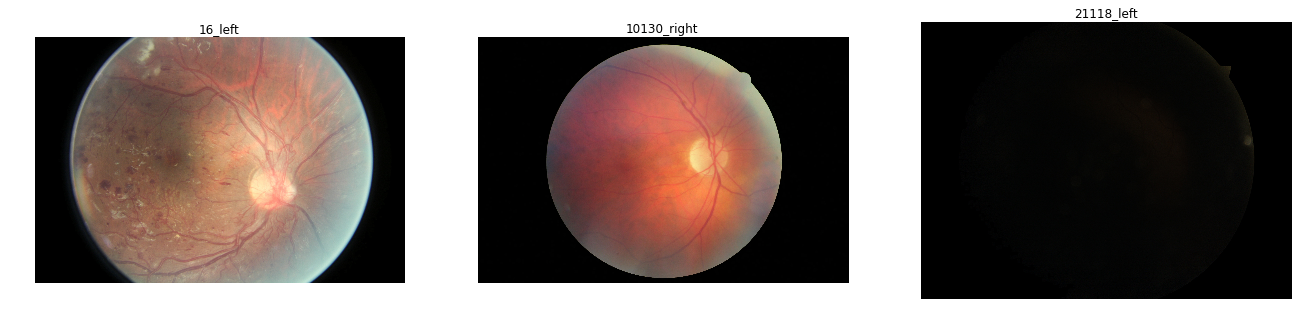

In [2]:
img_path = "/kaggle/retina/train/sample"

image_names = ["16_left.jpeg", "10130_right.jpeg", "21118_left.jpeg"]
image_paths = map(lambda t: path.join(img_path, t), image_names)
images = map(lambda p: cv2.imread(p), image_paths)

# let's see what we've got
image_titles = map(lambda i: path.splitext(i)[0], image_names)
show_images(images, image_titles, scale = 0.8)


##Prepare: PyrDown & Blurr

In [3]:
#Pyramid Down & blurr
# Easy-peesy
def pyr_blurr(image):
    return cv2.GaussianBlur(cv2.pyrDown(image), (7, 7), 30.)

images = map(lambda i: pyr_blurr(i), images)


##Find the Eye

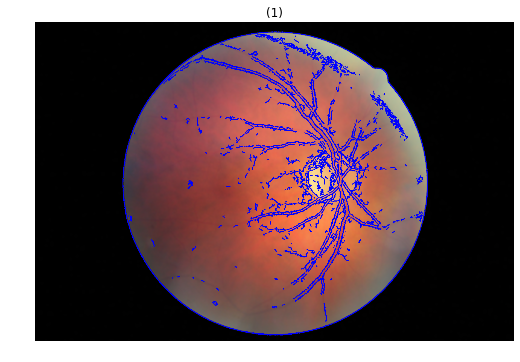

26935 points


In [4]:
# Function to display contours using OpenCV.
def display_contours(image, contours, color = (255, 0, 0), thickness = -1, title = None):
    # Contours are drawn on the original image, so let's make a copy first
    imShow = image.copy()
    for i in range(0, len(contours)):
        cv2.drawContours(imShow, contours, i, color, thickness)
    show_images([imShow], scale=0.7, titles=title)
    
image = images[1]

# this is a good threshold for Canny edge finder, but it does not always work. We will see how to deal with it furhter on.
thresh = 4
# Searcing for the eye
# Let's see how this works setp-by-step
# convert to a one channel image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Canny edge finder
edges = np.array([])
edges = cv2.Canny(gray, thresh, thresh * 3, edges)

# Find contours
# second output is hierarchy - we are not interested in it.
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Let's see what we've got:
display_contours(image, contours, thickness=2)
print "{:d} points".format(len(np.vstack(np.array(contours))))

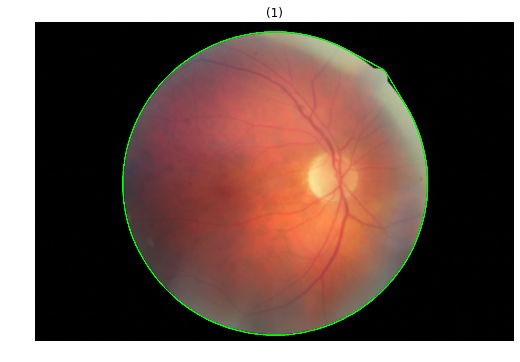

In [5]:
# Now let's get only what we need out of it
hull_contours = cv2.convexHull(np.vstack(np.array(contours)))
hull = np.vstack(hull_contours)

# we only get one contour out of it, let's see it
display_contours(image, [hull], thickness=3, color=(0, 255, 0))

Finally, in order to create a mask, we simply draw the hull on a totally black image, using "fill" collor white with the drawContours API.

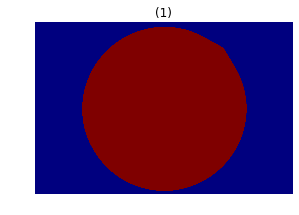

In [6]:
# Now let's create a mask for this image
def createMask((rows, cols), hull):
    # black image
    mask = np.zeros((rows, cols), dtype=np.uint8)
    # blit our contours onto it in white color
    cv2.drawContours(mask, [hull], 0, 255, -1)
    return mask

mask = createMask(image.shape[0:2], hull)

show_images([mask])

###Putting it all together:

In [7]:
def find_eye(image, thresh = 4):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Canny edge finder
    edges = np.array([])
    edges = cv2.Canny(gray, thresh, thresh * 3, edges)

    # Find contours
    # second output is hierarchy - we are not interested in it.
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Now let's get only what we need out of it
    hull_contours = cv2.convexHull(np.vstack(np.array(contours)))
    hull = np.vstack(hull_contours)
    
    def createMask((rows, cols), hull):
        # black image
        mask = np.zeros((rows, cols), dtype=np.uint8)
        # blit our contours onto it in white color
        cv2.drawContours(mask, [hull], 0, 255, -1)
        return mask

    mask = createMask(image.shape[0:2], hull)
    
    # returning the hull to illustrate a few issues below
    return mask, hull

In order to apply the mask, we just use numpy magic

Masked Background


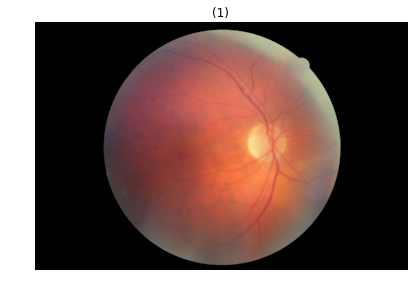

In [8]:
def mask_background(image, mask):
    # copy to preserve the original
    im = image.copy()
    im[mask == 0, :] = 0
    return im
    
# find the eye and get the background mask
mask, _ = find_eye(image)

maskedBg = mask_background(image, mask)
print "Masked Background"
show_images([maskedBg], scale=0.9)

How about 21118_left? This was an especially low quality image.

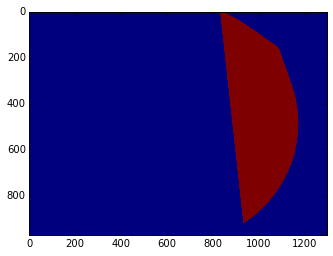

In [9]:
mask, _ = find_eye(images[2])
plt.imshow(mask)
plt.show()

Ok. This is not good. The image was too dark, so we need to set a lower threshold for the Canny filter

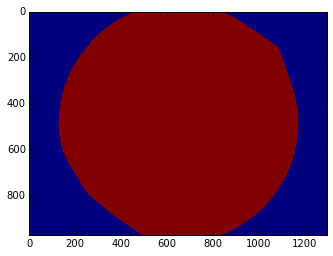

In [10]:
mask, _ = find_eye(images[2], 1)
plt.imshow(mask)
plt.show()

This is much better. A simple heuristic works pretty well on our data set: if the resulting mask occupies less than 41% percent of the image, we reduce the threshold to 1. We must be careful, though. If we approach the problem with this threshold at the very beginning i.e, set the threshold to 1 for all images, for many images we will catch a lot of background noise in our mask and it will be no mask at all!

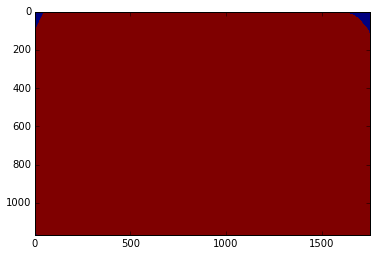

In [30]:
# Must be careful not to set the threshold too low from the start.
mask, _ = find_eye(images[1], 1)
plt.imshow(mask)
plt.show()